In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score

In [2]:
def load_MNIST_data(data_path, fashion=False, quiet=False):
    if not fashion:
        train_set = datasets.MNIST(data_path, download=True, train=True)
        test_set = datasets.MNIST(data_path, download=True, train=False)
    else:
        train_set = datasets.FashionMNIST(data_path, download=True, train=True)
        test_set = datasets.FashionMNIST(data_path, download=True, train=False)      
    x_train = train_set.data.numpy()
    y_train = train_set.targets.numpy()

    x_test = test_set.data.numpy()
    y_test = test_set.targets.numpy()
    
    N_train, H, W = x_train.shape
    N_test, H, W = x_test.shape

    if not quiet:
        print(f'The data are {H} x {W} grayscale images.')
        print(f'N_train = {N_train}')
        print(f'N_test = {N_test}')
    for i in set(y_train):
        N_i_train = np.sum(y_train==i)
        N_i_test = np.sum(y_test==i)
        if not quiet:
            print(f'Class {i}: has {N_i_train} train images ({100 * N_i_train / N_train : .2f} %), {N_i_test} test images ({100 * N_i_test/ N_test : .2f} %) ')
    return x_train, y_train, x_test, y_test

In [3]:
USE_FASHION_MNIST = True

x_train, y_train, x_test, y_test = load_MNIST_data('./data/', fashion=USE_FASHION_MNIST, quiet=False)


if USE_FASHION_MNIST:
    tag_name = 'FashionMNIST'
    label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
else:
    tag_name = 'MNIST'
    label_names = [f'{i}' for i in set(y_test)]

The data are 28 x 28 grayscale images.
N_train = 60000
N_test = 10000
Class 0: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 1: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 2: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 3: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 4: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 5: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 6: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 7: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 8: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 9: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 


<Figure size 640x480 with 0 Axes>

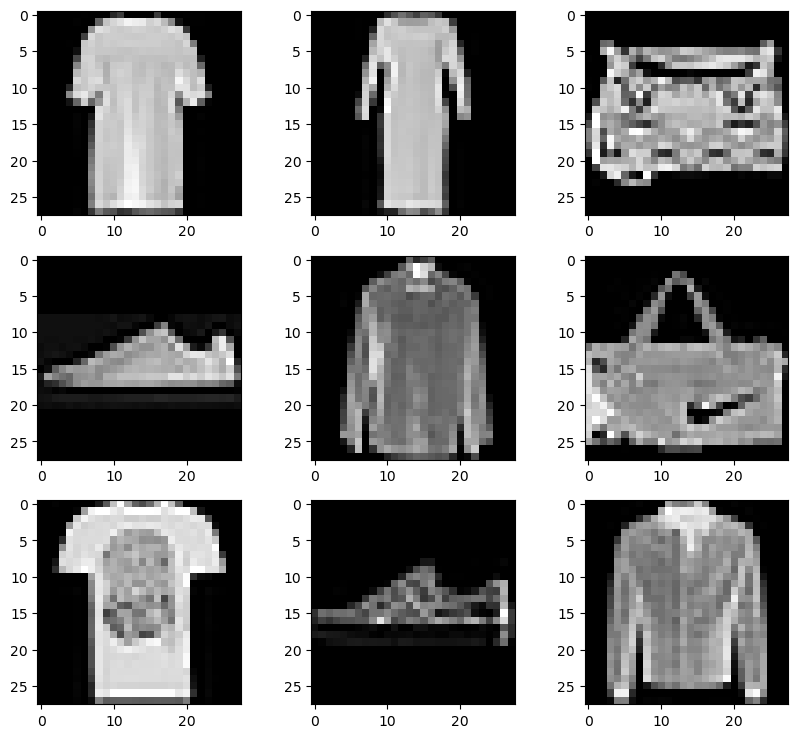

In [4]:
plt.gray() # B/W Images
plt.figure(figsize = (10,9)) # Adjusting figure size
# Displaying a grid of 3x3 images
for i in range(9):
    index = np.random.randint(low=0, high=len(y_train), dtype=int)
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[index])
plt.show()

In [5]:
def flatten_and_augment(x):
    N, H, W = x.shape
    D = H * W
    x_aug = np.ones((N, D + 1))
    x_aug[:, 1:] = x.reshape((N, D))
    return x_aug

def create_target_matrix(labels):
    label_vals = list(set(labels))
    C = len(label_vals)
    N = len(labels)
    y = -1 * np.ones((N, C)) 
    for n in range(N):
        y[n][labels[n]] = +1
    return y

In [6]:
x_train_float = x_train.astype("float32") 
x_test_float = x_test.astype("float32")
# Normalization
x_train_normalized = x_train_float/255.0
x_test_normalized = x_test_float/255.0

In [7]:
X_train = x_train_normalized.reshape(len(x_train_normalized),-1) #reshape to fed into k_means clustering
X_test = x_test_normalized.reshape(len(x_test_normalized),-1) #reshape to fed into k_means clustering

print(f'x_train_normalized.shape: {x_train_normalized.shape}')
print(f'X_train.shape: {X_train.shape}')

x_train_normalized.shape: (60000, 28, 28)
X_train.shape: (60000, 784)


In [8]:
def PCA(X_train):
    P = X_train.shape[0]
    Kx = X_train.T @ X_train / P ## sample covariance matrix

    e_vals, E_vecs = np.linalg.eig(Kx)

    E_vecs = E_vecs.T
    small_to_big = np.argsort(e_vals)
    big_to_small = small_to_big[::-1]

    e_vals = e_vals[big_to_small]
    E_vecs = E_vecs[big_to_small]

    return P, E_vecs, e_vals

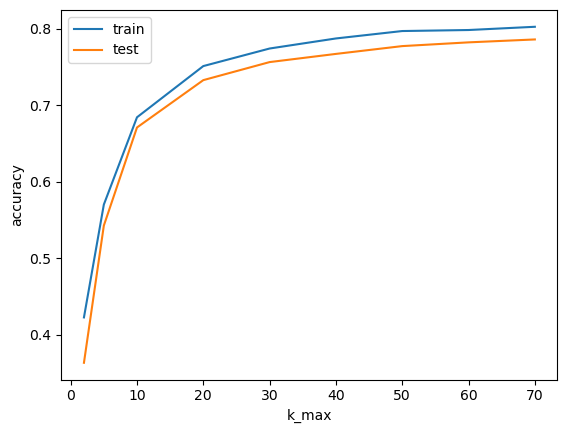

In [9]:
accuracy_train = []
accuracy_test = []
P, E_vecs, e_vals = PCA(X_train)
for k_max in [2, 5, 10, 20, 30, 40, 50, 60, 70]:
    coeff =  (E_vecs[:k_max] @ X_train.T).T
    X_approx = coeff @ E_vecs[:k_max]
    X_approx = X_approx.reshape(P, 28, 28)
    x_train_aug = flatten_and_augment(X_approx) #x_train need to be the training data with the reduced dimension
    Y = create_target_matrix(y_train)
    W_hat = np.linalg.lstsq(x_train_aug, Y, rcond=None)[0]
    y_train_hat = np.argmax(x_train_aug @ W_hat, axis=1)
    accuracy_i = np.mean(y_train_hat == y_train)
    #print (f'Accuracy for train = {accuracy_i}')
    accuracy_train.append(accuracy_i)

    # fit the model
    P_test = X_test.shape[0]
    coeff =  (E_vecs[:k_max] @ X_test.T).T
    X_approx_test = coeff @ E_vecs[:k_max]
    X_approx_test = X_approx_test.reshape(P_test, 28, 28)
    x_test_aug = flatten_and_augment(X_approx_test) #x_test is for evaluation of the model once you obtain W_hat
    y_test_hat = np.argmax(x_test_aug @ W_hat, axis=1)
    # create a array of accuracy
    accuracy_j = np.mean(y_test_hat == y_test)
    #print(f'Accuracy for test: {accuracy}')
    accuracy_test.append(accuracy_j)

plt.plot([2, 5, 10, 20, 30, 40, 50, 60, 70], accuracy_train, label='train')
plt.plot([2, 5, 10, 20, 30, 40, 50, 60, 70], accuracy_test, label='test')
plt.xlabel('k_max')
plt.ylabel('accuracy')
plt.legend()
plt.show()


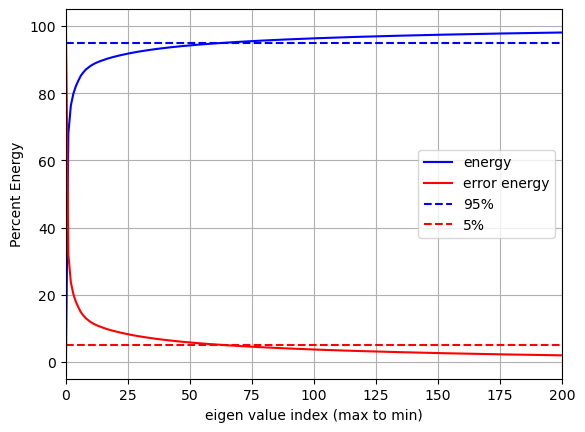

Percent energy retained by the first 70 eigen vectors: 95.23 %


In [10]:
H_W = len(e_vals)
percent_energy = np.zeros(H_W)
for k in range(H_W):
    percent_energy[k] = np.sum(e_vals[:k])
percent_energy = 100 * percent_energy / np.sum(e_vals)

plt.figure()
plt.plot(np.arange(H_W), percent_energy, color='b', label='energy')
plt.plot(np.arange(H_W), 100 - percent_energy, color='r', label='error energy')
plt.axhline(95, color='b', linestyle='--', label='95%')
plt.axhline(5, color='r', linestyle='--', label='5%')
plt.grid(';')
plt.legend()
plt.xlim([0,200])
plt.xlabel('eigen value index (max to min)')
plt.ylabel('Percent Energy')
plt.show()
# report the percentage of energy retained by the first k eigen vectors
print(f'Percent energy retained by the first {k_max} eigen vectors: {percent_energy[k_max-1]:.2f} %')